Please find jax implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/19/image_augmentation_jax.ipynb

<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks-d2l/image_augmentation_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Data augmentation for images

We illustrate some simple data augmentation methods form images.
Based on sec 13.1 of http://d2l.ai/chapter_computer-vision/image-augmentation.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed=1)
import math

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch import nn
from torch.nn import functional as F

try:
    import torchvision
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

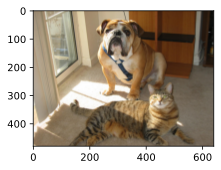

In [3]:
d2l.set_figsize()
# img = d2l.Image.open('../img/cat1.jpg')

# url = 'https://github.com/d2l-ai/d2l-en/blob/master/img/cat1.jpg?raw=true'
# url = 'https://github.com/probml/pyprobml/blob/master/images/cat_dog.jpg?raw=true'
url = "https://github.com/probml/probml-notebooks/blob/main/images/cat_dog.jpg?raw=true"

fname = "img.jpg"
!wget $url -q -O $fname


img = d2l.Image.open(fname)

d2l.plt.imshow(img);

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    return fig, axes

To visualize an image augmentation, which may be stochastic, we apply it multiple times to an image.


In [5]:
def apply(img, aug, num_rows=1, num_cols=4, scale=2):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    fig, axes = show_images(Y, num_rows, num_cols, scale=scale)
    return fig, axes

# Flipping

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f465bae8890>,
       dtype=object))

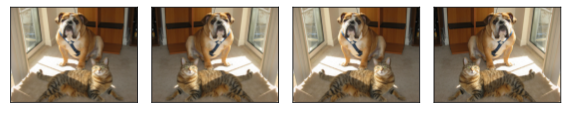

In [6]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f465b782e10>,
       dtype=object))

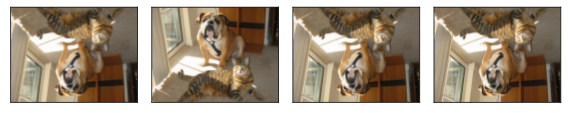

In [7]:
apply(img, torchvision.transforms.RandomVerticalFlip())

# Crop and resize

Below, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. 


(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4650436410>,
       dtype=object))

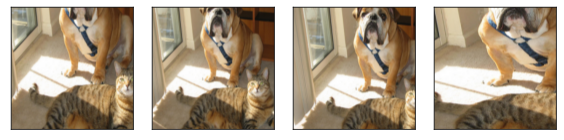

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

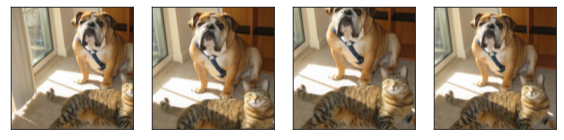

In [9]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.5, 1), ratio=(1, 1))
fig, axes = apply(img, shape_aug)
fig.savefig("dog_cat_augment.png")

# Changing color

We can change brightness, contrast, saturation and hue.
First we change brightness, from 1-0.5=0.5 times less to 1+0.5=1.5 times more.

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f46501b4a50>,
       dtype=object))

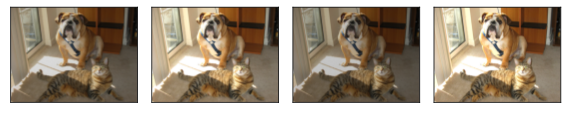

In [10]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

Now we change hue.

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f465007a5d0>,
       dtype=object))

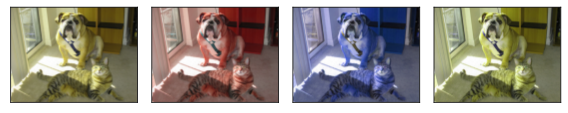

In [11]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

Now we change saturation.

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4639f43390>,
       dtype=object))

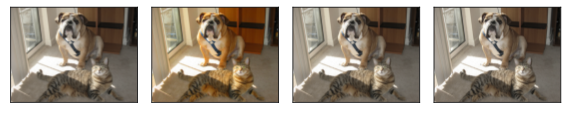

In [12]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.5, hue=0))

Now we change contrast.

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4639f17f10>,
       dtype=object))

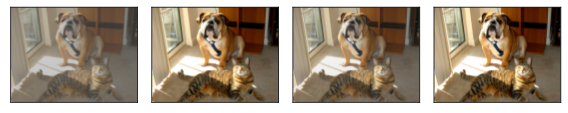

In [13]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0))

Now we change all of them.

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4639dcc210>,
       dtype=object))

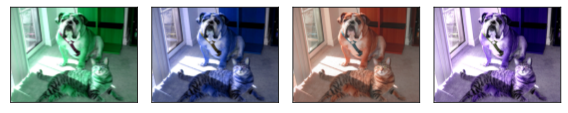

In [14]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

# Combining multiple augmentations in a pipeline

(<Figure size 576x144 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4639b60710>,
       dtype=object))

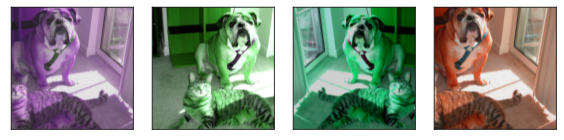

In [15]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

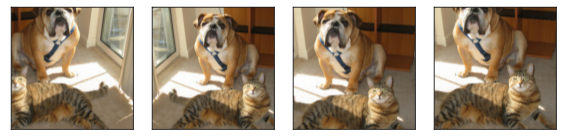

In [16]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), shape_aug])
fig, axes = apply(img, augs)
fig.savefig("dog_cat_augment2.png")

# Using augmentations in a dataloader

We illustrate how we can transform training and test images from CIFAR10.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


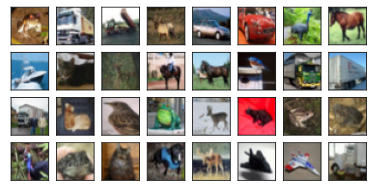

In [17]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [18]:
train_augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor()]
)

test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [19]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers()
    )
    return dataloader

In [20]:
train_iter = load_cifar10(True, train_augs, 32)
for i, (features, labels) in enumerate(train_iter):
    print(i)
    print(features.shape)
    if i >= 1:
        break

Files already downloaded and verified
0
torch.Size([32, 3, 32, 32])
1
torch.Size([32, 3, 32, 32])
